In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
listing = pd.read_excel('Paris airbnb listing.xlsx')
listing.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20250606142312,2025-06-20,city scrape,zen and calm,Lovely Appartment with one bedroom with a Quee...,Good restaurants<br />very close the Montparna...,https://a0.muscache.com/pictures/miso/Hosting-...,3631,...,5.00,5.00,5.00,7511409139079,f,1,1,0,0,0.08
1,5396,https://www.airbnb.com/rooms/5396,20250606142312,2025-06-19,city scrape,Your perfect Paris studio on Île Saint-Louis,"Cozy, well-appointed and graciously designed s...","You are within walking distance to the Louvre,...",https://a0.muscache.com/pictures/52413/f9bf76f...,7903,...,4.85,4.95,4.59,7510402838018,f,1,1,0,0,2.32
2,7397,https://www.airbnb.com/rooms/7397,20250606142312,2025-06-20,city scrape,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",NaN,https://a0.muscache.com/pictures/67928287/330b...,2626,...,4.89,4.94,4.74,7510400829623,f,1,1,0,0,2.20
3,7964,https://www.airbnb.com/rooms/7964,20250606142312,2025-06-18,previous scrape,Sunny apartment with balcony,"We are renting our a spacious, sunny fully fur...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,22155,...,5.00,5.00,5.00,7510903576564,f,1,1,0,0,0.03
4,9359,https://www.airbnb.com/rooms/9359,20250606142312,2025-06-18,city scrape,"Cozy, Central Paris: WALK or VELIB EVERYWHERE !",Location! Location! Location! Just bring your ...,NaN,https://a0.muscache.com/pictures/c2965945-061f...,28422,...,NaN,NaN,NaN,"Available with a mobility lease only (""bail mo...",f,1,1,0,0,NaN


In [3]:
listing.shape

(84055, 79)

## 1. Data

### 1.1 Deleting Irrelevant Columns

In [4]:
listing = listing.drop(['id','listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview',
                        'picture_url','host_id','host_url','host_name','host_about','host_thumbnail_url','host_picture_url',
                        'host_neighbourhood','neighbourhood_group_cleansed','latitude','longitude','property_type','amenities',
                        'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                        'maximum_nights_avg_ntm','calendar_updated','has_availability','availability_60','availability_90',
                        'calendar_last_scraped','estimated_occupancy_l365d','estimated_revenue_l365d','first_review','last_review',
                        'license','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                        'calculated_host_listings_count_shared_rooms','host_location','beds','reviews_per_month',
                        'host_verifications','host_response_rate','host_acceptance_rate','host_response_time'], axis=1)

In [5]:
listing.shape

(84055, 32)

### 1.2 Data Processing

In [6]:
listing['price']= listing['price'].str.replace('$','').str.replace(',','').astype(float)

In [7]:
listing['neighbourhood'] = listing['neighbourhood'].fillna("No Neighborhood highlights")
listing['bathrooms2'] = listing['bathrooms_text'].str.extract(r'(\d+\.?\d*)')

In [8]:
listing['bathrooms2'] = listing['bathrooms2'].fillna(listing['bathrooms'])
listing['bathrooms2'] = listing['bathrooms2'].astype(float)

In [9]:
listing=listing.drop(['bathrooms','bathrooms_text'],axis=1)

In [10]:
listing.shape

(84055, 31)

In [11]:
listing.columns

Index(['host_since', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'room_type', 'accommodates', 'bedrooms', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'availability_eoy', 'number_of_reviews_ly', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'bathrooms2'],
      dtype='object')

In [12]:
# create a new column of the host_years_run
listing['host_years_run'] = 2025 - pd.to_datetime(listing['host_since']).dt.year

In [13]:
# mapping
tourism = ['Louvre', 'Bourse', 'Temple', 'Hôtel-de-Ville', 'Panthéon', 'Luxembourg', 'Palais-Bourbon', 'Élysée']
mixed = ['Opéra', 'Entrepôt', 'Popincourt', 'Reuilly']
residential = ['Observatoire', 'Gobelins', 'Vaugirard', 'Batignolles-Monceau', 'Passy', 'Buttes-Montmartre', 'Buttes-Chaumont', 'Ménilmontant']

def classify_area(x):
    if x in tourism:
        return 'Tourism'
    elif x in mixed:
        return 'Mixed'
    elif x in residential:
        return 'Residential'
    else:
        return 'Other'
    
listing['district_group'] = listing['neighbourhood_cleansed'].apply(classify_area)

In [14]:
listing['district_group'].value_counts()

district_group
Residential    41576
Tourism        21853
Mixed          20626
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

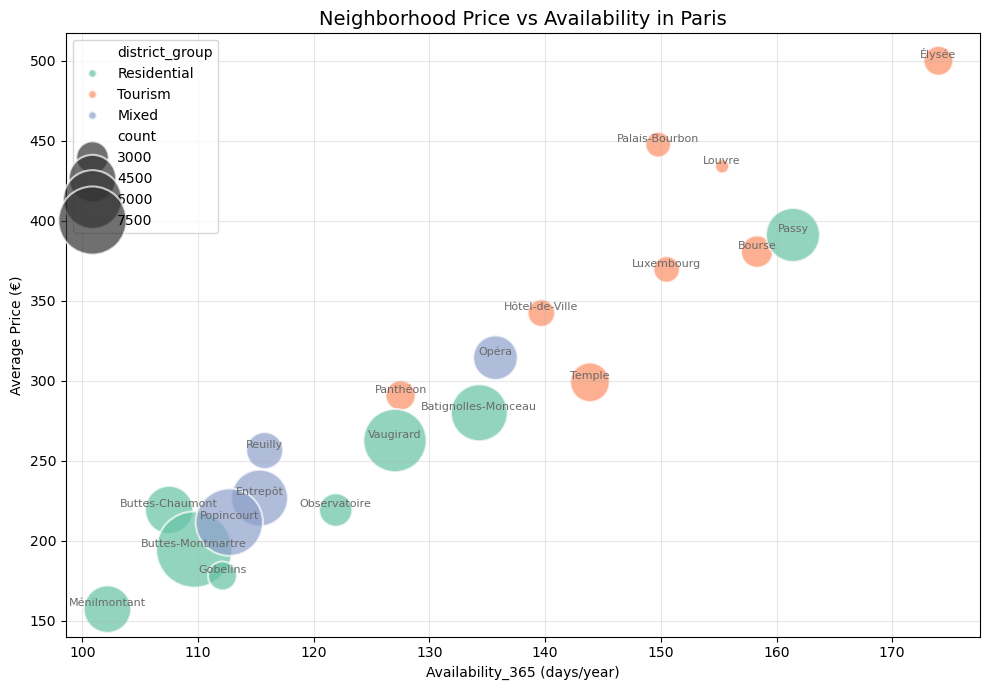

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bubble_df = listing.groupby(['neighbourhood_cleansed', 'district_group']).agg(
    avg_price=('price', 'mean'),
    avg_availability=('availability_365', 'mean'),
    count=('availability_365', 'count'),
    std_price=('price', 'std')
).reset_index()

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=bubble_df,
    x='avg_availability',     
    y='avg_price',            
    size='count',             
    hue='district_group',
    palette='Set2',
    sizes=(100, 3000),
    alpha=0.7
)

for i in range(bubble_df.shape[0]):
    plt.text(
        bubble_df.loc[i, 'avg_availability'],
        bubble_df.loc[i, 'avg_price'] + 0.5,
        bubble_df.loc[i, 'neighbourhood_cleansed'],
        ha='center', va='bottom',
        fontsize=8, color='dimgray'
    )

plt.title('Neighborhood Price vs Availability in Paris', fontsize=14)
plt.xlabel('Availability_365 (days/year)')
plt.ylabel('Average Price (€)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show


In [16]:
listing.drop(columns = ['host_since', 'neighbourhood_cleansed'], inplace=True)

In [17]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84055 entries, 0 to 84054
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               82227 non-null  object 
 1   host_listings_count             84029 non-null  float64
 2   host_total_listings_count       84029 non-null  float64
 3   host_has_profile_pic            84029 non-null  object 
 4   host_identity_verified          84029 non-null  object 
 5   neighbourhood                   84055 non-null  object 
 6   room_type                       84055 non-null  object 
 7   accommodates                    84055 non-null  int64  
 8   bedrooms                        76918 non-null  float64
 9   price                           53963 non-null  float64
 10  minimum_nights                  84055 non-null  int64  
 11  maximum_nights                  84055 non-null  int64  
 12  availability_30                 

### 1.3 Get Dummies

In [18]:
listing = pd.get_dummies(listing, columns=['host_is_superhost','host_has_profile_pic','host_identity_verified', 
                                           'neighbourhood','district_group','room_type','instant_bookable'],drop_first=True, dtype=int)

In [19]:
listing.shape

(84055, 34)

### 1.4 Missing Value

In [20]:
# replace null values with mean
mean_rating = listing['review_scores_rating'].mean()
listing.fillna({"review_scores_rating": mean_rating}, inplace=True)

mean_accuracy = listing['review_scores_accuracy'].mean()
listing.fillna({"review_scores_accuracy": mean_accuracy}, inplace=True)

mean_cleanliness = listing['review_scores_cleanliness'].mean()
listing.fillna({"review_scores_cleanliness": mean_cleanliness}, inplace=True)

mean_checkin = listing['review_scores_checkin'].mean()
listing.fillna({"review_scores_checkin": mean_checkin}, inplace=True)

mean_communication = listing['review_scores_communication'].mean()
listing.fillna({"review_scores_communication": mean_communication}, inplace=True)

mean_location = listing['review_scores_location'].mean()
listing.fillna({"review_scores_location": mean_location}, inplace=True)

mean_value = listing['review_scores_value'].mean()
listing.fillna({"review_scores_value": mean_value}, inplace=True)

In [21]:
listing2 = listing.dropna()

In [22]:
listing2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53781 entries, 0 to 84054
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   host_listings_count                       53781 non-null  float64
 1   host_total_listings_count                 53781 non-null  float64
 2   accommodates                              53781 non-null  int64  
 3   bedrooms                                  53781 non-null  float64
 4   price                                     53781 non-null  float64
 5   minimum_nights                            53781 non-null  int64  
 6   maximum_nights                            53781 non-null  int64  
 7   availability_30                           53781 non-null  int64  
 8   availability_365                          53781 non-null  int64  
 9   number_of_reviews                         53781 non-null  int64  
 10  number_of_reviews_ltm                  

### 1.5 Graph plot

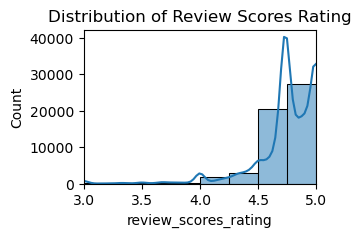

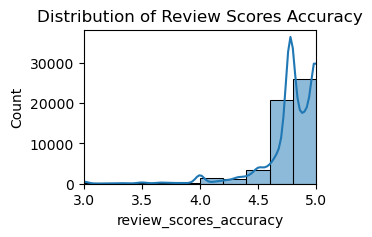

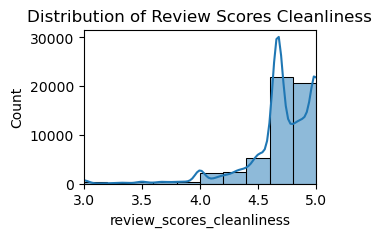

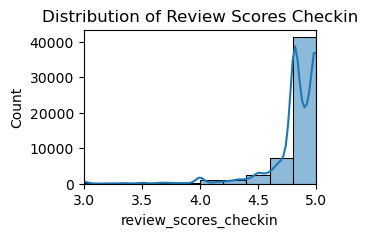

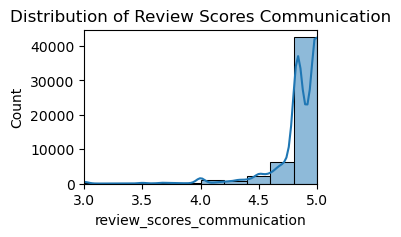

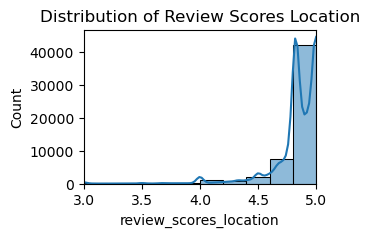

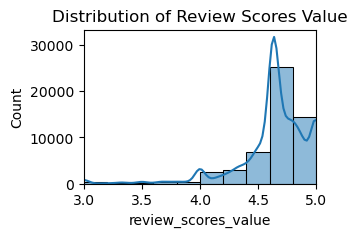

In [23]:
plt.figure(figsize=(3,2))
sns.histplot(data=listing2, x='review_scores_rating', bins=20, kde=True)
plt.title('Distribution of Review Scores Rating')
plt.xlim(3, 5)
plt.show()

plt.figure(figsize=(3,2))
sns.histplot(data=listing2, x='review_scores_accuracy', bins=20, kde=True)
plt.title('Distribution of Review Scores Accuracy')
plt.xlim(3, 5)
plt.show()

plt.figure(figsize=(3,2))
sns.histplot(data=listing2, x='review_scores_cleanliness', bins=20, kde=True)
plt.title('Distribution of Review Scores Cleanliness')
plt.xlim(3, 5)
plt.show()

plt.figure(figsize=(3,2))
sns.histplot(data=listing2, x='review_scores_checkin', bins=20, kde=True)
plt.title('Distribution of Review Scores Checkin')
plt.xlim(3, 5)
plt.show()

plt.figure(figsize=(3,2))
sns.histplot(data=listing2, x='review_scores_communication', bins=20, kde=True)
plt.title('Distribution of Review Scores Communication')
plt.xlim(3, 5)
plt.show()

plt.figure(figsize=(3,2))
sns.histplot(data=listing2, x='review_scores_location', bins=20, kde=True)
plt.title('Distribution of Review Scores Location')
plt.xlim(3, 5)
plt.show()

plt.figure(figsize=(3,2))
sns.histplot(data=listing2, x='review_scores_value', bins=20, kde=True)
plt.title('Distribution of Review Scores Value')
plt.xlim(3, 5)
plt.show()


## 2. Linear Regression

### 2.1 Define Dependent and Independent Variables

In [24]:
y = listing2.iloc[:, 4]
y

0        135.0
1        114.0
2        149.0
4         75.0
5         50.0
         ...  
84050     78.0
84051     89.0
84052    105.0
84053    100.0
84054    182.0
Name: price, Length: 53781, dtype: float64

In [25]:
x = listing2.iloc[:, listing2.columns != 'price']
x_c = sm.add_constant(x)
x

,host_listings_count,host_total_listings_count,accommodates,bedrooms,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,...,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_No Neighborhood highlights,district_group_Residential,district_group_Tourism,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_t
0,1.0,1.0,2,1.0,2,30,20,355,7,3,...,0,1,1,0,1,0,0,0,0,0
1,2.0,4.0,2,0.0,1,730,7,69,452,48,...,0,1,1,0,0,1,0,0,0,0
2,1.0,10.0,4,2.0,10,130,0,197,380,25,...,1,1,1,1,0,1,0,0,0,0
4,2.0,4.0,1,1.0,180,360,23,358,0,0,...,0,1,1,1,0,1,0,0,0,0
5,1.0,3.0,1,1.0,5,1125,21,82,63,3,...,0,1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84050,9.0,15.0,1,1.0,3,365,5,5,0,0,...,0,1,1,1,1,0,0,0,0,1
84051,1.0,1.0,2,1.0,1,365,17,352,0,0,...,0,0,1,1,0,0,0,0,0,1
84052,1.0,1.0,4,1.0,3,365,10,333,0,0,...,0,1,1,1,1,0,0,0,0,0
84053,1.0,2.0,3,1.0,3,15,16,195,0,0,...,0,1,0,1,1,0,0,0,0,1


### 2.1.2 Running linear regression

In [26]:
reg = sm.OLS(y, x_c).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     222.5
Date:                Mon, 20 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:29:22   Log-Likelihood:            -4.2394e+05
No. Observations:               53781   AIC:                         8.479e+05
Df Residuals:                   53747   BIC:                         8.482e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### 2.1.3 Checking Linearity & Normality

In [27]:
y_pred = reg.predict()

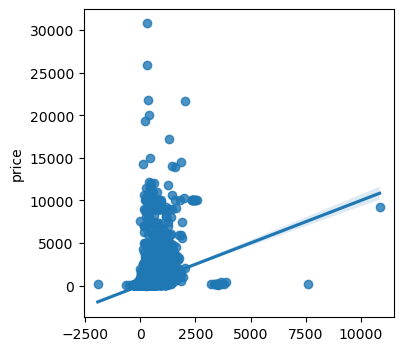

In [28]:
plt.figure(figsize=(4,4))
sns.regplot(x = y_pred, y = y)
plt.show()

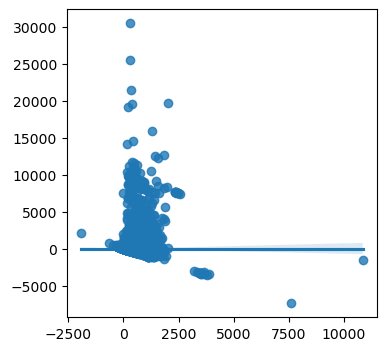

In [29]:
residual = reg.resid
plt.figure(figsize=(4,4))
sns.regplot(x = y_pred, y = residual)
plt.show()

<Figure size 400x400 with 0 Axes>

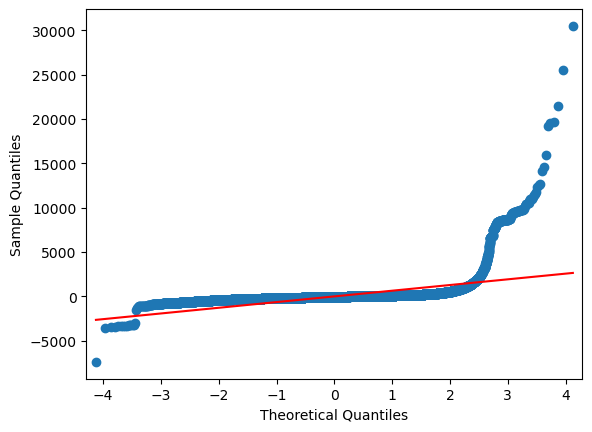

In [30]:
# normality test of errors
plt.figure(figsize=(4,4))
sm.qqplot(residual, line="s")
plt.show()

### 2.1.4 Checking Outliers

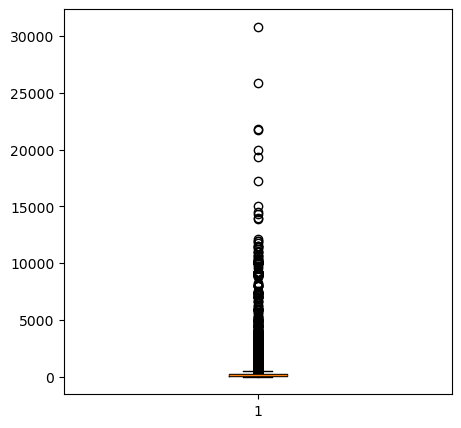

In [31]:
plt.figure(figsize=(5,5))
plt.boxplot(listing2["price"])
plt.show()

### 2.2.1 Removing Outlier_IQR Method

In [32]:
Q1 = listing2["price"].quantile(0.25)
Q3 = listing2["price"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

In [33]:
listing3 = listing2[(listing2["price"] >= lower) & (listing2["price"] <= upper)]

In [34]:
listing2.shape

(53781, 34)

In [35]:
listing3.shape

(49296, 34)

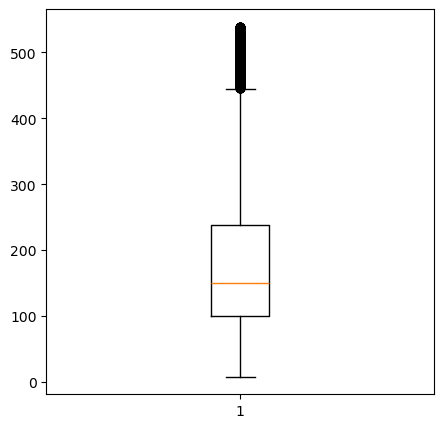

In [36]:
plt.figure(figsize=(5,5))
plt.boxplot(listing3["price"])
plt.show()

### 2.2.2 Log transformation

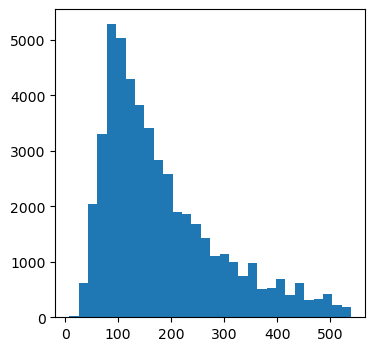

In [37]:
plt.figure(figsize=(4,4))
plt.hist(listing3["price"], bins=30)
plt.show()

In [38]:
log_price = np.log(listing3["price"]+1)

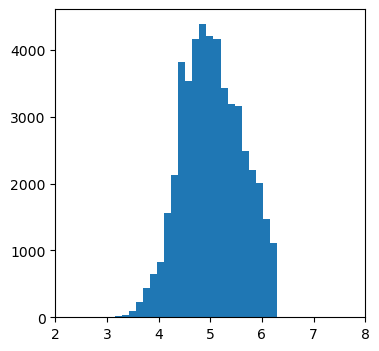

In [39]:
# want to show the x axis from 2 to 8
# want to make the bins smaller
plt.figure(figsize=(4,4))
plt.hist(log_price, bins=30)
plt.xlim(2, 8)
plt.show()

### 2.3 Linear Regression (w/ IQR, Log Transform)

In [40]:
y2 = log_price
x2 = listing3.iloc[:, listing3.columns != 'price']
x2_c = sm.add_constant(x2)

In [41]:
reg2 = sm.OLS(y2, x2_c).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     1315.
Date:                Mon, 20 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:29:36   Log-Likelihood:                -27862.
No. Observations:               49296   AIC:                         5.579e+04
Df Residuals:                   49262   BIC:                         5.609e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

<Axes: >

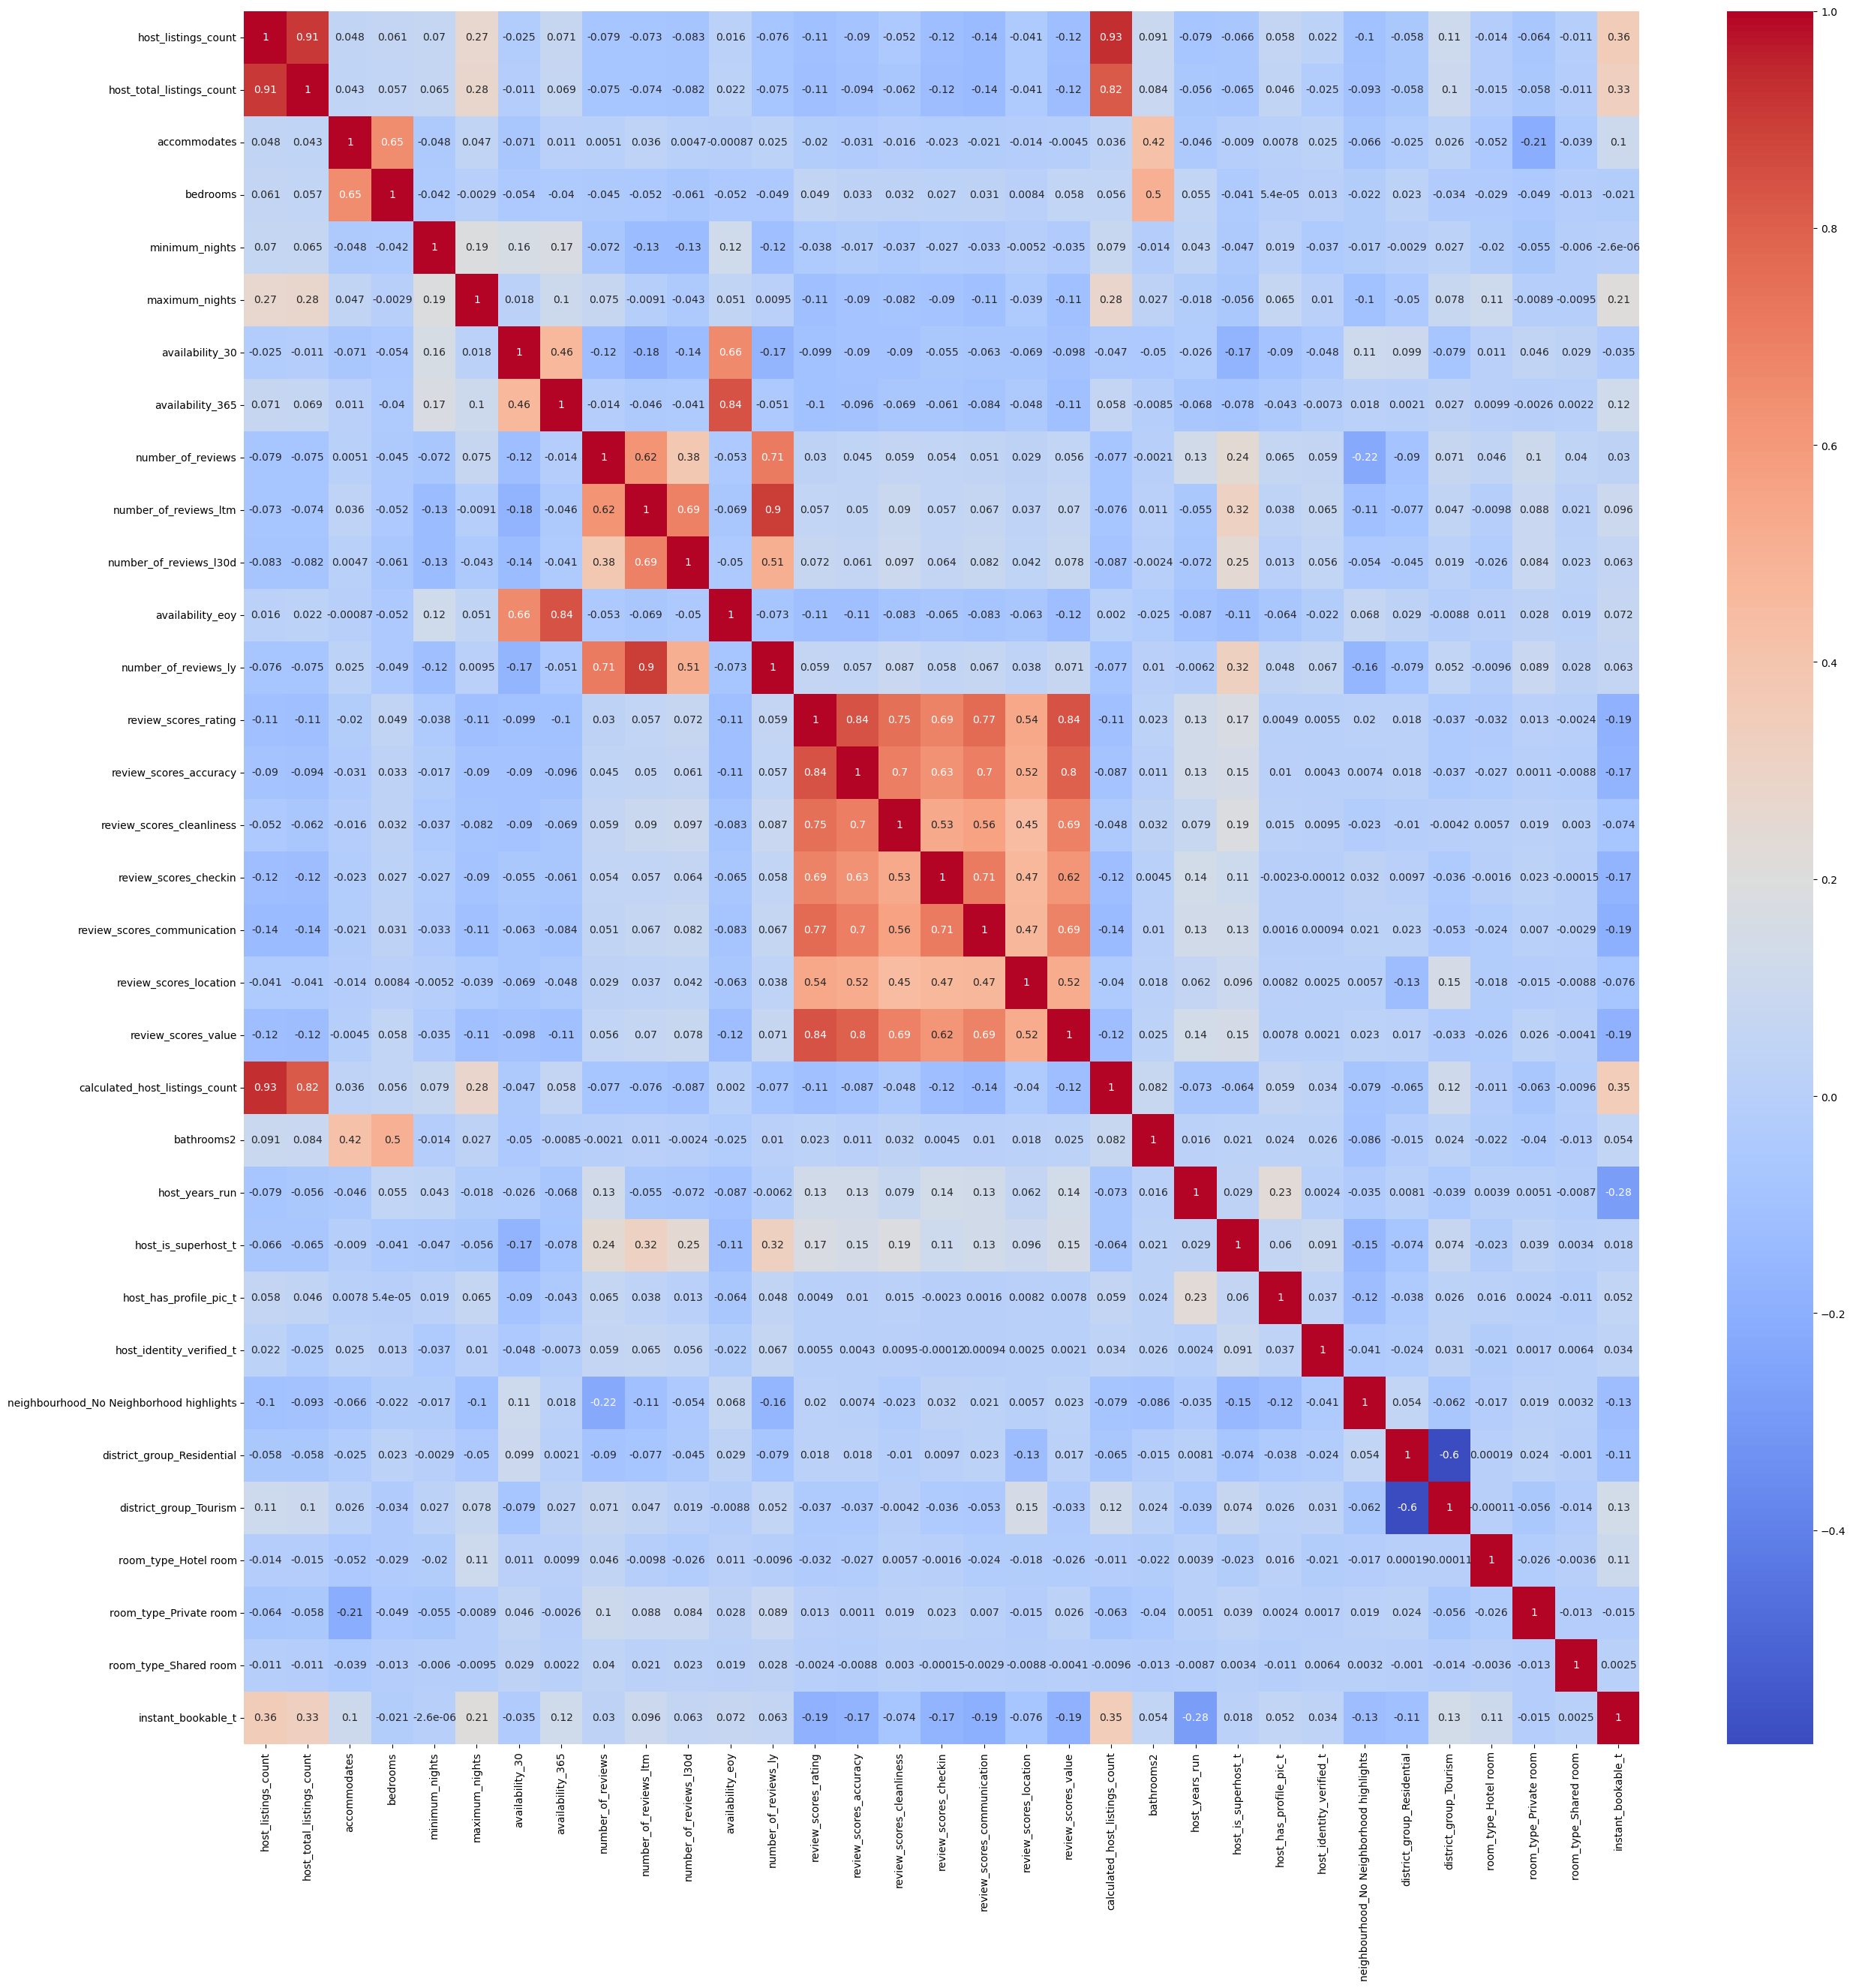

In [52]:
corrs = x2.corr()
plt.figure(figsize = (30, 30))
sns.heatmap(corrs, annot=True, cmap='coolwarm')

### 2.3.1 Checking Linearity & Normality (after)

In [42]:
y_pred2 = reg2.predict()

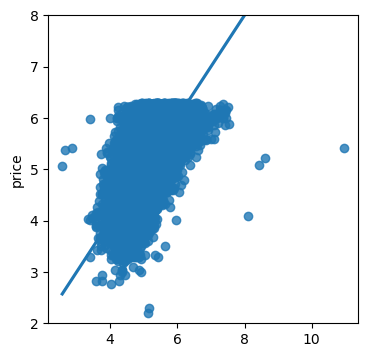

In [43]:
# only show the y axis from 2 to 8
plt.figure(figsize=(4,4))
sns.regplot(x = y_pred2, y = y2)
plt.ylim(2, 8)
plt.show()

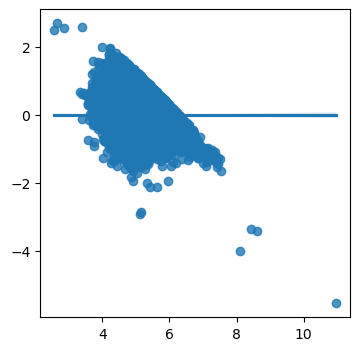

In [44]:
residual2 = reg2.resid
plt.figure(figsize=(4,4))
sns.regplot(x = y_pred2, y = residual2)
plt.show()

<Figure size 400x400 with 0 Axes>

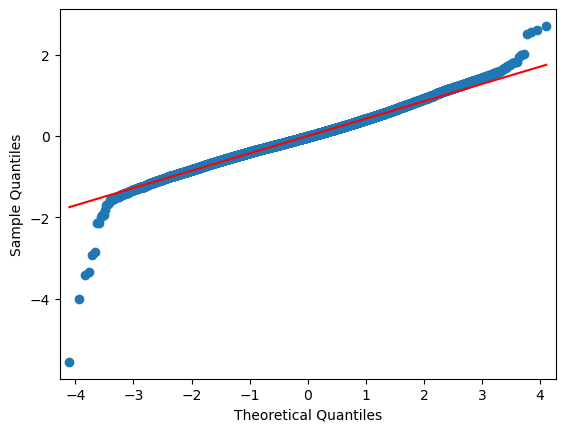

In [45]:
plt.figure(figsize=(4,4))
sm.qqplot(residual2, line="s")
plt.show()

### 2.3.2 Checking Multicolinearity & Homoscedasticity

In [46]:
# checking multicolinearity by deleting variables with high VIF factors
## Delete review_scores_rating first

x2_multi = x2.drop(columns=['availability_eoy', 'review_scores_rating','host_has_profile_pic_t','bedrooms',
                            'review_scores_accuracy', 'review_scores_cleanliness','host_identity_verified_t',
                            'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
                            'number_of_reviews','number_of_reviews_ly','host_listings_count','host_total_listings_count'])
vif(x2_multi.values, 0)
vif_factors = [vif(x2_multi.values, i) for i in range(0, x2_multi.shape[1])]
pd.DataFrame({"Variable": x2_multi.columns, "VIF Factor": vif_factors}).sort_values("VIF Factor", ascending=False)

,Variable,VIF Factor
8,bathrooms2,8.079592
0,accommodates,6.286543
4,availability_365,4.299245
9,host_years_run,3.922223
5,number_of_reviews_ltm,2.816956
3,availability_30,2.701299
12,district_group_Residential,2.661261
6,number_of_reviews_l30d,2.652537
2,maximum_nights,2.301601
13,district_group_Tourism,1.999339


<Axes: >

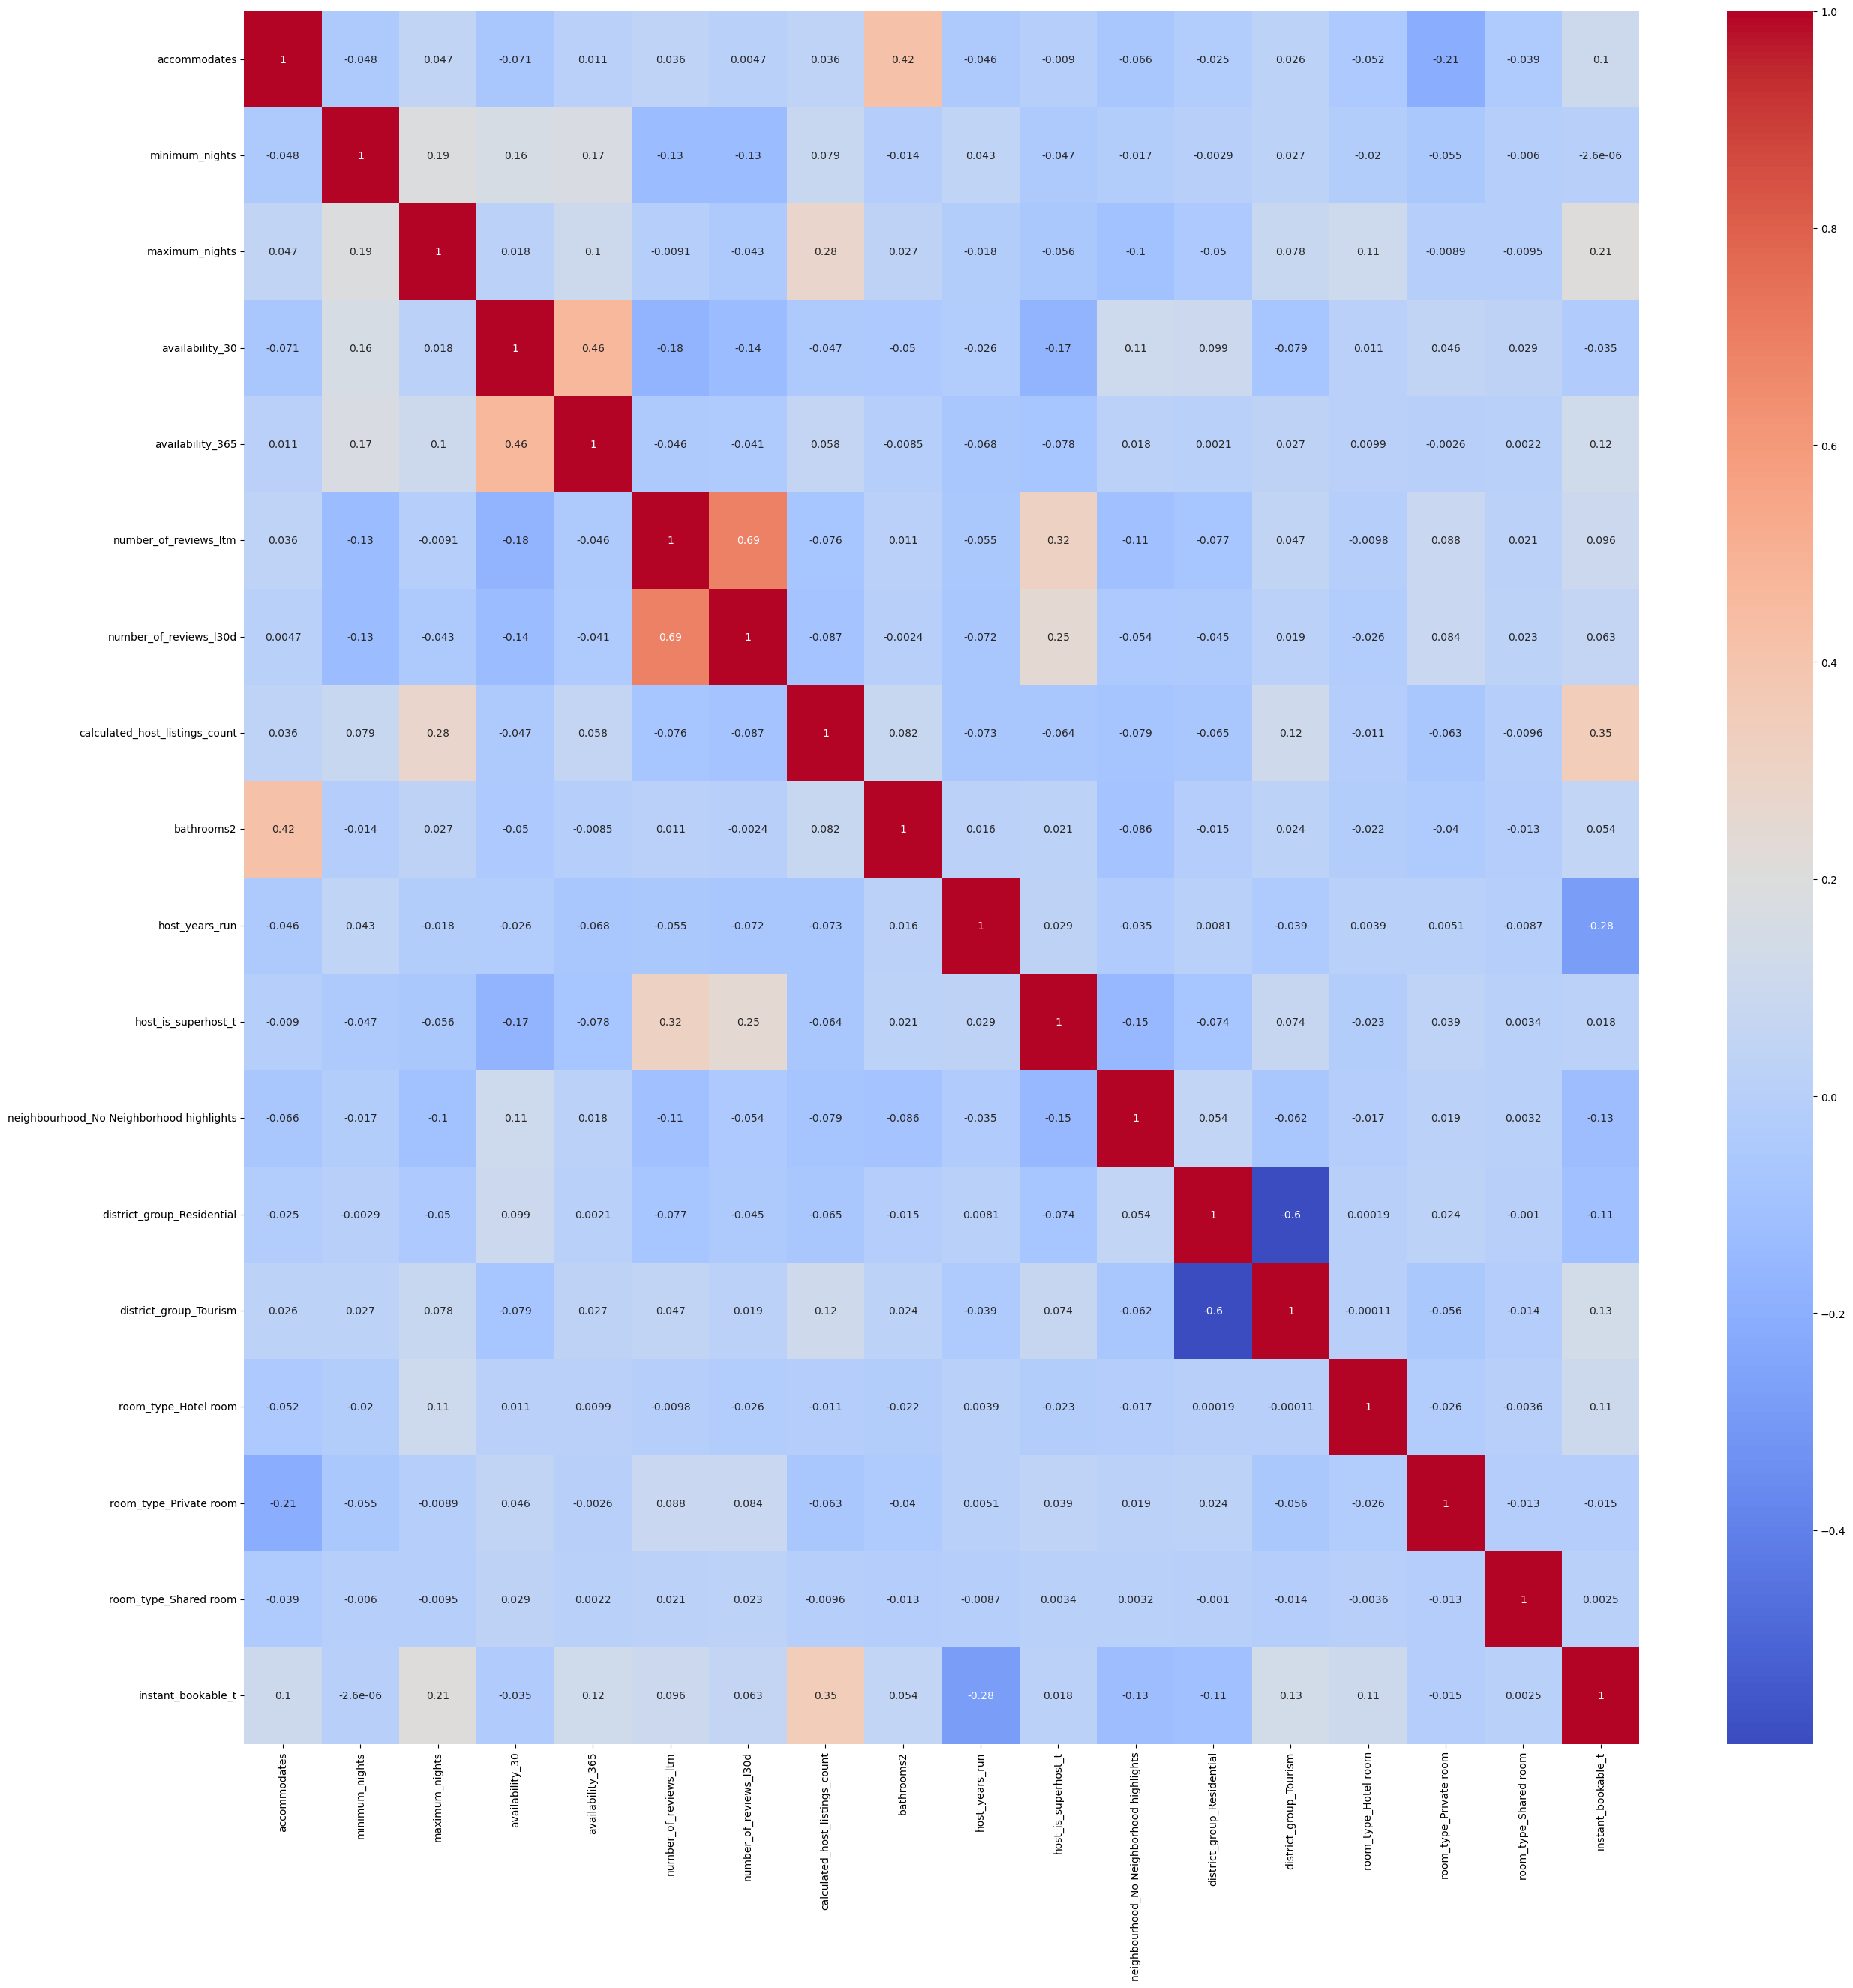

In [53]:
corrs = x2_multi.corr()
plt.figure(figsize = (30, 30))
sns.heatmap(corrs, annot=True, cmap='coolwarm')

In [48]:
# homoscedasticity test
residual = reg2.resid
exog = reg2.model.exog
bp_test = sm.stats.het_breuschpagan(residual, exog)
bp_test

(np.float64(6425.641467569163),
 np.float64(0.0),
 np.float64(223.74713029208036),
 np.float64(0.0))

In [49]:
# make the bp test results as a dataframe
labels = ["Test Statistics","p-value", "f statistics", "f p-value"]
bp_test_df = pd.DataFrame(list(zip(labels, bp_test)), columns=["Metric", "Value"])
bp_test_df

,Metric,Value
0,Test Statistics,6425.641468
1,p-value,0.000000
2,f statistics,223.747130
3,f p-value,0.000000


In [50]:
x2_multi_c = sm.add_constant(x2_multi)
reg3 = sm.OLS(y2, x2_multi_c).fit(cov_type='HC3')
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     1678.
Date:                Mon, 20 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:29:49   Log-Likelihood:                -29712.
No. Observations:               49296   AIC:                         5.946e+04
Df Residuals:                   49277   BIC:                         5.963e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------